# ***Problem Defenition***
 ***Overfitting:***

When do we say that overfitting has happened? 

In some situations, the model works perfectly on train data and it has high accuracy, however, it has low accuracy in valid and test data! In these situations, we say the model has been overfitted!





# ***Solution***
**Some methods to avoid overfitting**

- Cross-validation
- Train with more data
- Remove features
- Adding drop out
- Early stopping
- Regularization

**My choices in this implimentation**

- Reduce the capacity of the network (Simplifying the model)
- Add weight regularization
- Add dropout
- Early stopping

Note: We could also shuffle the data at the begining if it was not shuffled! In this example, cifar is the standard


Sources:
1.   https://elitedatascience.com/overfitting-in-machine-learning
2.   https://keras.rstudio.com/articles/tutorial_overfit_underfit.html
3. https://towardsdatascience.com/dont-overfit-how-to-prevent-overfitting-in-your-deep-learning-models-63274e552323




# ***Solve the problem for classification in Keras***

In [0]:
import keras
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
import os
from keras.layers import Flatten, Dense, Concatenate
from keras.optimizers import SGD
from keras.layers import Input
from keras.models import Model

import matplotlib.pyplot as plt
from prettytable import PrettyTable
from tensorflow.keras import regularizers
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [0]:
#Reading the Dataset
# classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#normalization
X_train = X_train / 255.0
X_test = X_test / 255.0
         
#one-hot
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


How to display multiple images in one figure correctly?

https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645

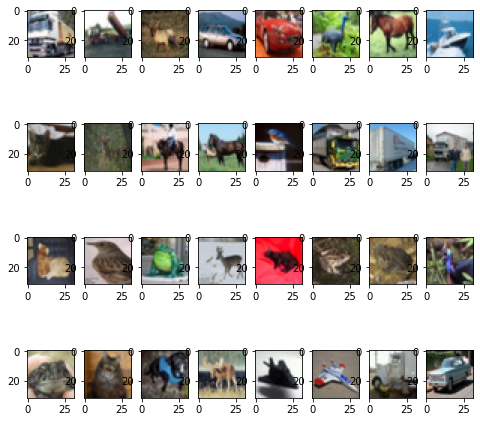

In [0]:
# visualize some (4*8) of the samples in cifar10 train set

fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i])
plt.show()

In [0]:
#input layer
input_img = Input(shape = (32, 32, 3))

***baseline model***

In [0]:
out_l = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
out_l = Conv2D(128, (3,3), padding='same', activation='relu')(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu')(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu')(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu')(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu')(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out  = Dense(10, activation='softmax')(output)

model = Model(inputs = input_img, outputs = out)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 128)  73856       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 256)  33024       conv2d_2[0][0]                   
____________________________________________________________________________________________

***Dropout***

In [0]:
#architecture 1 - with dropout = 0.2 - model 1

out_l = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
out_l = Dropout(0.2)(out_l)
out_l = Conv2D(128, (3,3), padding='same', activation='relu')(out_l)
out_l = Dropout(0.2)(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu')(out_l)
out_l = Dropout(0.2)(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_1 = Dropout(0.2)(path_1)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu')(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Dropout(0.2)(path_2)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu')(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Dropout(0.2)(path_3)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu')(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out    = Dense(10, activation='softmax')(output)

model1 = Model(inputs = input_img, outputs = out)
print(model1.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 32, 32, 64)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 128)  73856       dropout_4[0][0]                  
____________________________________________________________________________________________

In [0]:
#architecture 1-2 - with dropout 0.3 - model 1_2

out_l = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
out_l = Dropout(0.3)(out_l)
out_l = Conv2D(128, (3,3), padding='same', activation='relu')(out_l)
out_l = Dropout(0.3)(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu')(out_l)
out_l = Dropout(0.3)(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_1 = Dropout(0.3)(path_1)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu')(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Dropout(0.3)(path_2)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu')(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Dropout(0.3)(path_3)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu')(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out    = Dense(10, activation='softmax')(output)

model1_2 = Model(inputs = input_img, outputs = out)
#print(model1_2.summary())

In [0]:
#architecture 1-3 - with dropout 0.4 - model1_3

out_l = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
out_l = Dropout(0.4)(out_l)
out_l = Conv2D(128, (3,3), padding='same', activation='relu')(out_l)
out_l = Dropout(0.4)(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu')(out_l)
out_l = Dropout(0.4)(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_1 = Dropout(0.4)(path_1)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu')(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Dropout(0.4)(path_2)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu')(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Dropout(0.4)(path_3)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu')(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out  = Dense(10, activation='softmax')(output)

model1_3 = Model(inputs = input_img, outputs = out)
#print(model1_3.summary())

In [0]:
#architecture 1-4 - with dropout 0.5 - model 1_4

out_l = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
out_l = Dropout(0.5)(out_l)
out_l = Conv2D(128, (3,3), padding='same', activation='relu')(out_l)
out_l = Dropout(0.5)(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu')(out_l)
out_l = Dropout(0.5)(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_1 = Dropout(0.5)(path_1)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu')(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Dropout(0.5)(path_2)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu')(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Dropout(0.5)(path_3)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu')(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out  = Dense(10, activation='softmax')(output)

model1_4 = Model(inputs = input_img, outputs = out)
#print(model1_4.summary())

***Regularization***

In [0]:
#architecture 1_5 - with l1 regularization - model1_5

out_l = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(input_img)
out_l = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(out_l)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out    = Dense(10, activation='softmax')(output)

model1_5 = Model(inputs = input_img, outputs = out)
print(model1_5.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 32, 32, 128)  73856       conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 32, 32, 256)  33024       conv2d_45[0][0]                  
____________________________________________________________________________________________

In [0]:
#architecture 1-6 - with keras.regularizers.l2 - model 1_6

out_l = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_img)
out_l = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(out_l)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out   = Dense(10, activation='softmax')(output)

model1_6 = Model(inputs = input_img, outputs = out)
print(model1_6.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 32, 32, 128)  73856       conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 32, 32, 256)  33024       conv2d_60[0][0]                  
____________________________________________________________________________________________

In [0]:
#architecture 1-7 - with keras.regularizers.l1_l2 - model 1_7

out_l = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(input_img)
out_l = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(out_l)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(out_l)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out  = Dense(10, activation='softmax')(output)

model1_7 = Model(inputs = input_img, outputs = out)
print(model1_7.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 32, 32, 128)  73856       conv2d_74[0][0]                  
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 32, 32, 256)  33024       conv2d_75[0][0]                  
____________________________________________________________________________________________

***Simplifying the basline model***

In [0]:
#architecture 1-8 - model1_8
out_l = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)

#inception module with 3 paths
#first path
path_1 = Conv2D(32, (1,1), padding='same', activation='relu')(out_l)
path_1 = Conv2D(32, (3,3), padding='same', activation='relu')(path_1)

#second path
path_2 = Conv2D(32, (1,1), padding='same', activation='relu')(out_l)
path_2 = Conv2D(32, (5,5), padding='same', activation='relu')(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Conv2D(32, (1,1), padding='same', activation='relu')(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out  = Dense(10, activation='softmax')(output)

model1_8 = Model(inputs = input_img, outputs = out)
print(model1_8.summary())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 32, 32, 32)   2080        conv2d_82[0][0]                  
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 32, 32, 32)   2080        conv2d_82[0][0]                  
____________________________________________________________________________________________

***Using early stoping on the basline model***

In [0]:
#architecture 1-9 - model1_9

# Set callback functions to early stop training and save the best model
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

out_l = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
out_l = Conv2D(128, (3,3), padding='same', activation='relu')(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu')(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu')(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu')(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu')(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output = Flatten()(out_l)
out  = Dense(10, activation='softmax')(output)

model1_9 = Model(inputs = input_img, outputs = out)
print(model1_9.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 32, 32, 128)  73856       conv2d_88[0][0]                  
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 32, 32, 256)  33024       conv2d_89[0][0]                  
___________________________________________________________________________________________

***Train***

In [0]:
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=256)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 83s 2ms/step - loss: 1.7743 - accuracy: 0.3679 - val_loss: 1.4742 - val_accuracy: 0.4689
Epoch 2/25
50000/50000 [==============================] - 75s 2ms/step - loss: 1.3494 - accuracy: 0.5232 - val_loss: 1.2068 - val_accuracy: 0.5656
Epoch 3/25
50000/50000 [==============================] - 75s 2ms/step - loss: 1.1168 - accuracy: 0.6078 - val_loss: 1.0513 - val_accuracy: 0.6294
Epoch 4/25
50000/50000 [==============================] - 75s 2ms/step - loss: 0.9587 - accuracy: 0.6662 - val_loss: 1.0036 - val_accuracy: 0.6456
Epoch 5/25
50000/50000 [==============================] - 75s 2ms/step - loss: 0.8523 - accuracy: 0.7059 - val_loss: 0.9371 - val_accuracy: 0.6732
Epoch 6/25
50000/50000 [==============================] - 75s 2ms/step - loss: 0.7661 - accuracy: 0.7361 - val_loss: 0.9223 - val_accuracy: 0.6821
Epoch 7/25
50000/50000 [==============================] - 75s 2ms/st

In [0]:
# train model1

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 136s 3ms/step - loss: 1.7785 - accuracy: 0.3666 - auc: 0.7387 - recall: 0.0476 - precision: 0.5389 - val_loss: 1.6533 - val_accuracy: 0.3961 - val_auc: 0.8081 - val_recall: 0.1020 - val_precision: 0.6480
Epoch 2/25
50000/50000 [==============================] - 135s 3ms/step - loss: 1.4648 - accuracy: 0.4774 - auc: 0.8284 - recall: 0.1372 - precision: 0.6628 - val_loss: 1.3664 - val_accuracy: 0.5174 - val_auc: 0.8451 - val_recall: 0.1710 - val_precision: 0.6786
Epoch 3/25
50000/50000 [==============================] - 135s 3ms/step - loss: 1.2918 - accuracy: 0.5430 - auc: 0.8571 - recall: 0.2003 - precision: 0.6914 - val_loss: 1.3380 - val_accuracy: 0.5269 - val_auc: 0.8669 - val_recall: 0.2272 - val_precision: 0.7004
Epoch 4/25
50000/50000 [==============================] - 134s 3ms/step - loss: 1.1842 - accuracy: 0.5819 - auc: 0.8746 - recall: 0.2502 - precision: 0.7081 - val_l

In [0]:
# train model1_2

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1_2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1_2 = model1_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1_2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 134s 3ms/step - loss: 1.8145 - accuracy: 0.3545 - auc_1: 0.7305 - recall_1: 0.0419 - precision_1: 0.5590 - val_loss: 1.8971 - val_accuracy: 0.3135 - val_auc_1: 0.7931 - val_recall_1: 0.0828 - val_precision_1: 0.6436
Epoch 2/25
50000/50000 [==============================] - 134s 3ms/step - loss: 1.4955 - accuracy: 0.4671 - auc_1: 0.8133 - recall_1: 0.1145 - precision_1: 0.6601 - val_loss: 1.6691 - val_accuracy: 0.4208 - val_auc_1: 0.8305 - val_recall_1: 0.1435 - val_precision_1: 0.6722
Epoch 3/25
50000/50000 [==============================] - 134s 3ms/step - loss: 1.3702 - accuracy: 0.5111 - auc_1: 0.8414 - recall_1: 0.1646 - precision_1: 0.6804 - val_loss: 1.4266 - val_accuracy: 0.5123 - val_auc_1: 0.8517 - val_recall_1: 0.1863 - val_precision_1: 0.6899
Epoch 4/25
50000/50000 [==============================] - 133s 3ms/step - loss: 1.2562 - accuracy: 0.5528 - auc_1: 0.8600 - reca

In [0]:
# train model1_3

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1_3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1_3 = model1_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1_3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 137s 3ms/step - loss: 1.8226 - accuracy: 0.3532 - auc_2: 0.7370 - recall_2: 0.0442 - precision_2: 0.5485 - val_loss: 1.9446 - val_accuracy: 0.3131 - val_auc_2: 0.7909 - val_recall_2: 0.0768 - val_precision_2: 0.6298
Epoch 2/25
50000/50000 [==============================] - 136s 3ms/step - loss: 1.5076 - accuracy: 0.4609 - auc_2: 0.8100 - recall_2: 0.1065 - precision_2: 0.6503 - val_loss: 1.8445 - val_accuracy: 0.3664 - val_auc_2: 0.8258 - val_recall_2: 0.1339 - val_precision_2: 0.6638
Epoch 3/25
50000/50000 [==============================] - 135s 3ms/step - loss: 1.3508 - accuracy: 0.5162 - auc_2: 0.8367 - recall_2: 0.1570 - precision_2: 0.6744 - val_loss: 1.8217 - val_accuracy: 0.3819 - val_auc_2: 0.8462 - val_recall_2: 0.1808 - val_precision_2: 0.6835
Epoch 4/25
50000/50000 [==============================] - 136s 3ms/step - loss: 1.2462 - accuracy: 0.5577 - auc_2: 0.8536 - reca

In [0]:
# train model1_4

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1_4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1_4 = model1_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1_4.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 135s 3ms/step - loss: 1.8308 - accuracy: 0.3480 - auc_3: 0.7333 - recall_3: 0.0429 - precision_3: 0.5283 - val_loss: 1.9697 - val_accuracy: 0.3062 - val_auc_3: 0.7885 - val_recall_3: 0.0752 - val_precision_3: 0.6159
Epoch 2/25
50000/50000 [==============================] - 136s 3ms/step - loss: 1.5311 - accuracy: 0.4546 - auc_3: 0.8066 - recall_3: 0.1012 - precision_3: 0.6372 - val_loss: 1.8027 - val_accuracy: 0.3721 - val_auc_3: 0.8231 - val_recall_3: 0.1272 - val_precision_3: 0.6543
Epoch 3/25
50000/50000 [==============================] - 136s 3ms/step - loss: 1.4156 - accuracy: 0.4922 - auc_3: 0.8332 - recall_3: 0.1466 - precision_3: 0.6646 - val_loss: 1.8610 - val_accuracy: 0.3406 - val_auc_3: 0.8408 - val_recall_3: 0.1638 - val_precision_3: 0.6718
Epoch 4/25
50000/50000 [==============================] - 135s 3ms/step - loss: 1.3281 - accuracy: 0.5262 - auc_3: 0.8470 - reca

In [0]:
# train model1_5

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1_5.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1_5 = model1_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1_5.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 104s 2ms/step - loss: 22.1620 - accuracy: 0.2499 - auc_4: 0.6621 - recall_4: 6.7673e-04 - precision_4: 0.3786 - val_loss: 2.1953 - val_accuracy: 0.2912 - val_auc_4: 0.7039 - val_recall_4: 0.0023 - val_precision_4: 0.5109
Epoch 2/25
50000/50000 [==============================] - 103s 2ms/step - loss: 2.1290 - accuracy: 0.2926 - auc_4: 0.7171 - recall_4: 0.0048 - precision_4: 0.5447 - val_loss: 2.0654 - val_accuracy: 0.3185 - val_auc_4: 0.7262 - val_recall_4: 0.0077 - val_precision_4: 0.5689
Epoch 3/25
50000/50000 [==============================] - 104s 2ms/step - loss: 2.0624 - accuracy: 0.3070 - auc_4: 0.7327 - recall_4: 0.0102 - precision_4: 0.5833 - val_loss: 2.0311 - val_accuracy: 0.3078 - val_auc_4: 0.7378 - val_recall_4: 0.0125 - val_precision_4: 0.5886
Epoch 4/25
50000/50000 [==============================] - 104s 2ms/step - loss: 2.0309 - accuracy: 0.3126 - auc_4: 0.7417 -

In [0]:
# train model1_6

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1_6.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1_6 = model1_6.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1_6.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 105s 2ms/step - loss: 6.2702 - accuracy: 0.3622 - auc_5: 0.7352 - recall_5: 0.0459 - precision_5: 0.5517 - val_loss: 4.8056 - val_accuracy: 0.4677 - val_auc_5: 0.8097 - val_recall_5: 0.1043 - val_precision_5: 0.6636
Epoch 2/25
50000/50000 [==============================] - 103s 2ms/step - loss: 4.0158 - accuracy: 0.4738 - auc_5: 0.8309 - recall_5: 0.1415 - precision_5: 0.6816 - val_loss: 3.3137 - val_accuracy: 0.5099 - val_auc_5: 0.8458 - val_recall_5: 0.1727 - val_precision_5: 0.6883
Epoch 3/25
50000/50000 [==============================] - 104s 2ms/step - loss: 2.8531 - accuracy: 0.5232 - auc_5: 0.8562 - recall_5: 0.1976 - precision_5: 0.6951 - val_loss: 2.4607 - val_accuracy: 0.5387 - val_auc_5: 0.8648 - val_recall_5: 0.2189 - val_precision_5: 0.7024
Epoch 4/25
50000/50000 [==============================] - 104s 2ms/step - loss: 2.2067 - accuracy: 0.5544 - auc_5: 0.8716 - reca

In [0]:
# train model1_7

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1_7.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1_7 = model1_7.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1_7.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 106s 2ms/step - loss: 24.4276 - accuracy: 0.2485 - auc_6: 0.6668 - recall_6: 7.2260e-04 - precision_6: 0.5411 - val_loss: 2.2006 - val_accuracy: 0.2871 - val_auc_6: 0.7049 - val_recall_6: 0.0042 - val_precision_6: 0.5503
Epoch 2/25
50000/50000 [==============================] - 105s 2ms/step - loss: 2.1577 - accuracy: 0.2876 - auc_6: 0.7153 - recall_6: 0.0072 - precision_6: 0.5532 - val_loss: 2.0961 - val_accuracy: 0.3159 - val_auc_6: 0.7236 - val_recall_6: 0.0093 - val_precision_6: 0.5608
Epoch 3/25
50000/50000 [==============================] - 106s 2ms/step - loss: 2.1031 - accuracy: 0.3003 - auc_6: 0.7291 - recall_6: 0.0108 - precision_6: 0.5779 - val_loss: 2.0705 - val_accuracy: 0.3060 - val_auc_6: 0.7330 - val_recall_6: 0.0122 - val_precision_6: 0.5840
Epoch 4/25
50000/50000 [==============================] - 105s 2ms/step - loss: 2.0731 - accuracy: 0.3059 - auc_6: 0.7363 -

In [0]:
# train model1_8

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1_8.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1_8 = model1_8.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1_8.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 35s 698us/step - loss: 1.6742 - accuracy: 0.4064 - auc_7: 0.7709 - recall_7: 0.0697 - precision_7: 0.6319 - val_loss: 1.4099 - val_accuracy: 0.5046 - val_auc_7: 0.8369 - val_recall_7: 0.1493 - val_precision_7: 0.6911
Epoch 2/25
50000/50000 [==============================] - 34s 685us/step - loss: 1.3344 - accuracy: 0.5303 - auc_7: 0.8566 - recall_7: 0.1959 - precision_7: 0.7072 - val_loss: 1.2450 - val_accuracy: 0.5570 - val_auc_7: 0.8711 - val_recall_7: 0.2360 - val_precision_7: 0.7184
Epoch 3/25
50000/50000 [==============================] - 34s 686us/step - loss: 1.1935 - accuracy: 0.5822 - auc_7: 0.8809 - recall_7: 0.2656 - precision_7: 0.7268 - val_loss: 1.1764 - val_accuracy: 0.5794 - val_auc_7: 0.8888 - val_recall_7: 0.2921 - val_precision_7: 0.7341
Epoch 4/25
50000/50000 [==============================] - 34s 682us/step - loss: 1.0980 - accuracy: 0.6179 - auc_7: 0.8951 - 

In [0]:
# train model1_9

epochs = 25
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1_9.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history1_9 = model1_9.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1_9.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 103s 2ms/step - loss: 1.7116 - accuracy: 0.3924 - auc_8: 0.7488 - recall_8: 0.0587 - precision_8: 0.5941 - val_loss: 1.4339 - val_accuracy: 0.4816 - val_auc_8: 0.8277 - val_recall_8: 0.1395 - val_precision_8: 0.6838
Epoch 2/25
50000/50000 [==============================] - 104s 2ms/step - loss: 1.2966 - accuracy: 0.5429 - auc_8: 0.8520 - recall_8: 0.1924 - precision_8: 0.7022 - val_loss: 1.2180 - val_accuracy: 0.5702 - val_auc_8: 0.8705 - val_recall_8: 0.2421 - val_precision_8: 0.7197
Epoch 3/25
50000/50000 [==============================] - 103s 2ms/step - loss: 1.0962 - accuracy: 0.6162 - auc_8: 0.8831 - recall_8: 0.2802 - precision_8: 0.7311 - val_loss: 1.0320 - val_accuracy: 0.6404 - val_auc_8: 0.8939 - val_recall_8: 0.3151 - val_precision_8: 0.7422
Epoch 4/25
50000/50000 [==============================] - 103s 2ms/step - loss: 0.9518 - accuracy: 0.6699 - auc_8: 0.9026 - reca

# ***Visualize evaluation after  dropout***

***Visualizing accuracy***

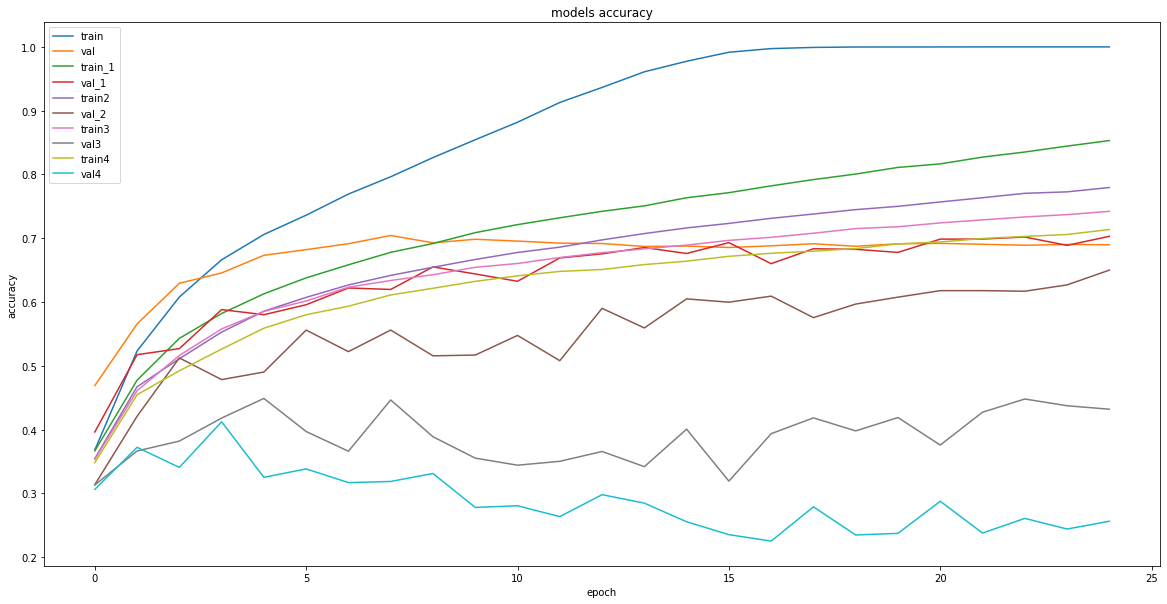

In [0]:
plt.figure(figsize=(20,10))
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
 
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
 
plt.plot(history1_2.history['accuracy'])
plt.plot(history1_2.history['val_accuracy'])
 
plt.plot(history1_3.history['accuracy'])
plt.plot(history1_3.history['val_accuracy'])
 
plt.plot(history1_4.history['accuracy'])
plt.plot(history1_4.history['val_accuracy'])
 
 
plt.title('models accuracy')
 
plt.ylabel('accuracy')
plt.xlabel('epoch')
 
#Baseline --> train - val
#model1 --> train1 - val1 - 0.2 dropout
#model1_2 --> train2 - val2 - 0.3 dropout
#model1_3 --> train3 - val3 - 0.4 dropout
#model1_4 --> train4 - val4 - 0.5 dropout
plt.legend(['train', 'val', 'train_1', 'val_1', 'train2' , 'val_2', 'train3', 'val3', 'train4', 'val4'])
plt.show()

Legend:
- Baseline --> train - val
- model1 --> train1 - val1 - 0.2 dropout
- model1_2 --> train2 - val2 - 0.3 dropout
- model1_3 --> train3 - val3 - 0.4 dropout
- model1_4 --> train4 - val4 - 0.5 dropout

My analyse:

Using dropout 0.2 was more useful in this model. As you can see in the graph, the accuracy of the validation of the model with 0.2 drop out (which is red) at epoch 25, is more than val accuracy of the baseline (which is orange). It has also decreased the overfitting.

However, the train accuracy of the baseline is more than all of them. And I think I could use Early-Stopping to have better accuracy by stopping baseline model at the begining, e.g., epoch 7.

And it is interesting for me, that using 0.5 drop out was too bad!

***Visualizing [AUC](https://keras.io/api/metrics/classification_metrics/#auc-class)***

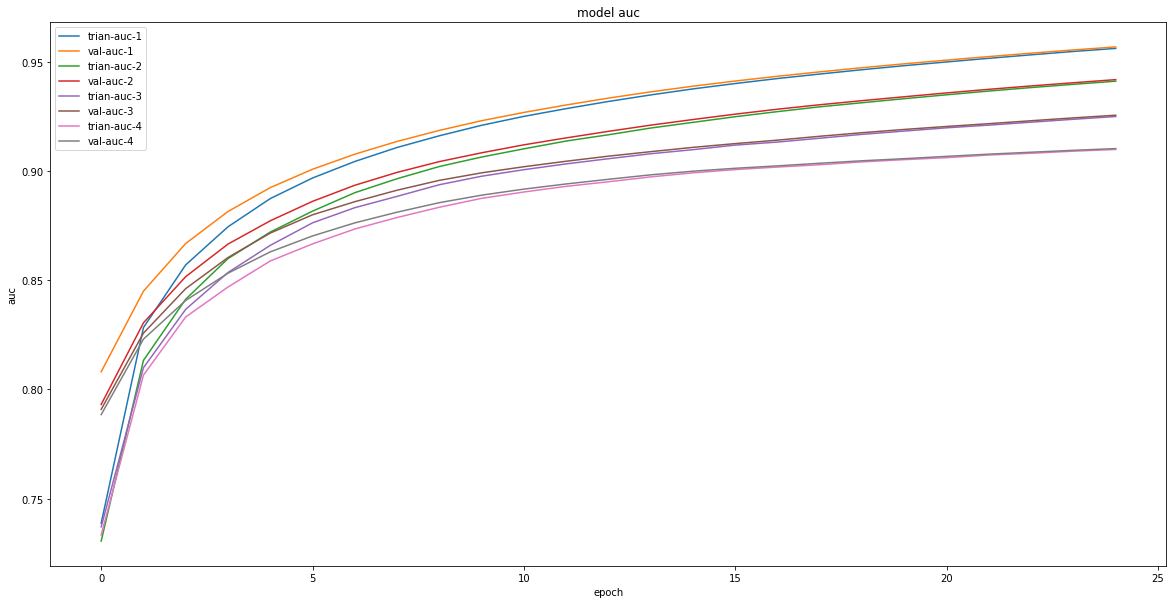

In [0]:
plt.figure(figsize=(20,10))
 
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
 
plt.plot(history1_2.history['auc_1'])
plt.plot(history1_2.history['val_auc_1'])
 
plt.plot(history1_3.history['auc_2'])
plt.plot(history1_3.history['val_auc_2'])
 
plt.plot(history1_4.history['auc_3'])
plt.plot(history1_4.history['val_auc_3'])
 
 
plt.title('model auc')
 
plt.ylabel('auc')
plt.xlabel('epoch')
 
#model1 --> train1 - val1 - 0.2 dropout
#model1_2 --> train2 - val2 - 0.3 dropout
#model1_3 --> train3 - val3 - 0.4 dropout
#model1_4 --> train4 - val4 - 0.5 dropout
 
plt.legend(['trian-auc-1', 'val-auc-1', 'trian-auc-2','val-auc-2' ,'trian-auc-3','val-auc-3','trian-auc-4','val-auc-4'])
plt.show()

Legend:
- model1 --> train1 - val1 - 0.2 dropout
- model1_2 --> train2 - val2 - 0.3 dropout
- model1_3 --> train3 - val3 - 0.4 dropout
- model1_4 --> train4 - val4 - 0.5 dropout

My analyse:

According to auc graph, using 0.2 dropout is the best choice to avoid overfitting in the baseline model. And using 0.5 dropout is the worth choice. However, we saw in the accuracy results that the basline model can work better than the others by using early stopping.

***Visualizing precision and recall***

"Precision and recall are two extremely important model evaluation metrics. While precision refers to the percentage of your results which are relevant, recall refers to the percentage of total relevant results correctly classified by your algorithm.", [ref](https://towardsdatascience.com/precision-vs-recall-386cf9f89488)

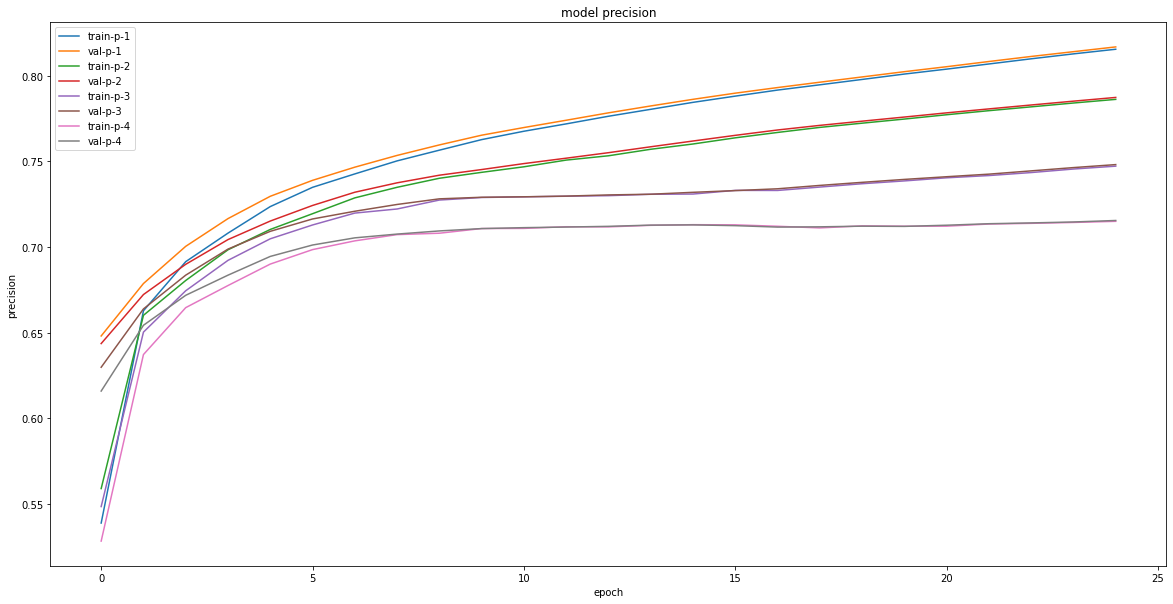

In [0]:
plt.figure(figsize=(20,10))

plt.plot(history1.history['precision'])
plt.plot(history1.history['val_precision'])

plt.plot(history1_2.history['precision_1'])
plt.plot(history1_2.history['val_precision_1'])

plt.plot(history1_3.history['precision_2'])
plt.plot(history1_3.history['val_precision_2'])

plt.plot(history1_4.history['precision_3'])
plt.plot(history1_4.history['val_precision_3'])

plt.title('model precision')

plt.ylabel('precision')
plt.xlabel('epoch')


#model1 --> train1 - val1
#model1_2 --> train2 - val2
#model1_3 --> train3 - val3
#model1_4 --> train4 - val4
plt.legend(['train-p-1', 'val-p-1' , 'train-p-2', 'val-p-2', 'train-p-3', 'val-p-3', 'train-p-4', 'val-p-4'])
plt.show()

Legend:
- model1 --> train1 - val1 - 0.2 dropout
- model1_2 --> train2 - val2 - 0.3 dropout
- model1_3 --> train3 - val3 - 0.4 dropout
- model1_4 --> train4 - val4 - 0.5 dropout

My analyse:

Precision graph's result is the same as auc. Using 0.2 dropout is better than others. And using 0.5 dropout is not good as it is less accurate.

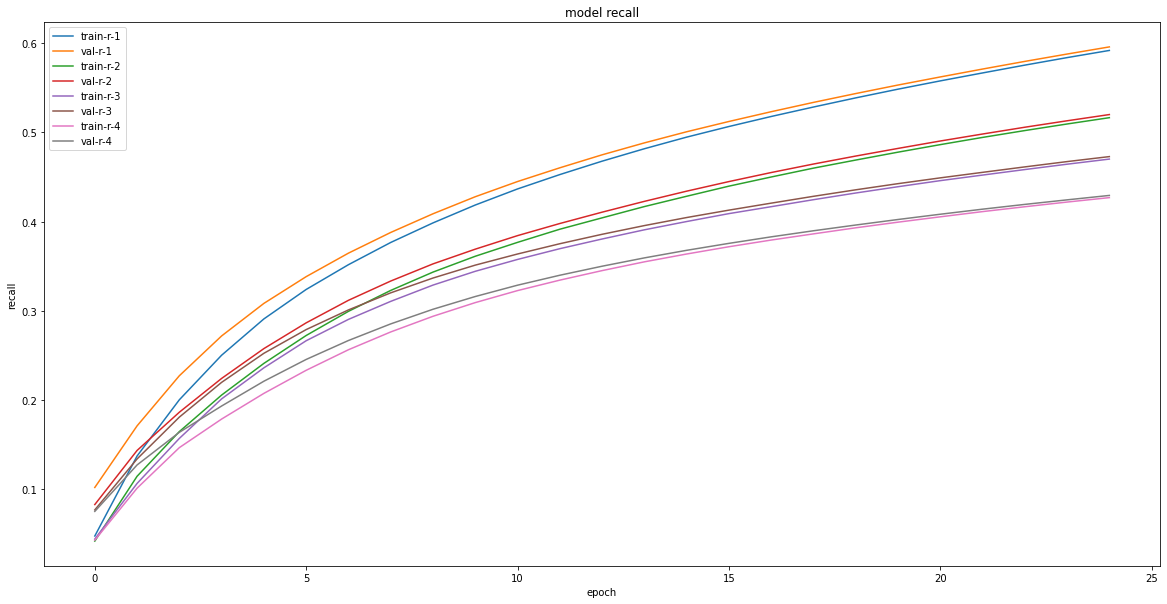

In [0]:
plt.figure(figsize=(20,10))

plt.plot(history1.history['recall'])
plt.plot(history1.history['val_recall'])

plt.plot(history1_2.history['recall_1'])
plt.plot(history1_2.history['val_recall_1'])

plt.plot(history1_3.history['recall_2'])
plt.plot(history1_3.history['val_recall_2'])

plt.plot(history1_4.history['recall_3'])
plt.plot(history1_4.history['val_recall_3'])


plt.title('model recall')

plt.ylabel('recall')
plt.xlabel('epoch')

#model1 --> train1 - val1
#model1_2 --> train2 - val2
#model1_3 --> train3 - val3
#model1_4 --> train4 - val4
plt.legend(['train-r-1', 'val-r-1', 'train-r-2', 'val-r-2','train-r-3', 'val-r-3', 'train-r-4', 'val-r-4'])
plt.show()

Legend:
- model1 --> train1 - val1 - 0.2 dropout
- model1_2 --> train2 - val2 - 0.3 dropout
- model1_3 --> train3 - val3 - 0.4 dropout
- model1_4 --> train4 - val4 - 0.5 dropout

My analyse:

In recall graph, same as previous results, using 0.2 dropout is the best choice.

Note: Precision was more than recall.

# ***Visualize evaluation after Regurarization***

***Visualizing accuracy***

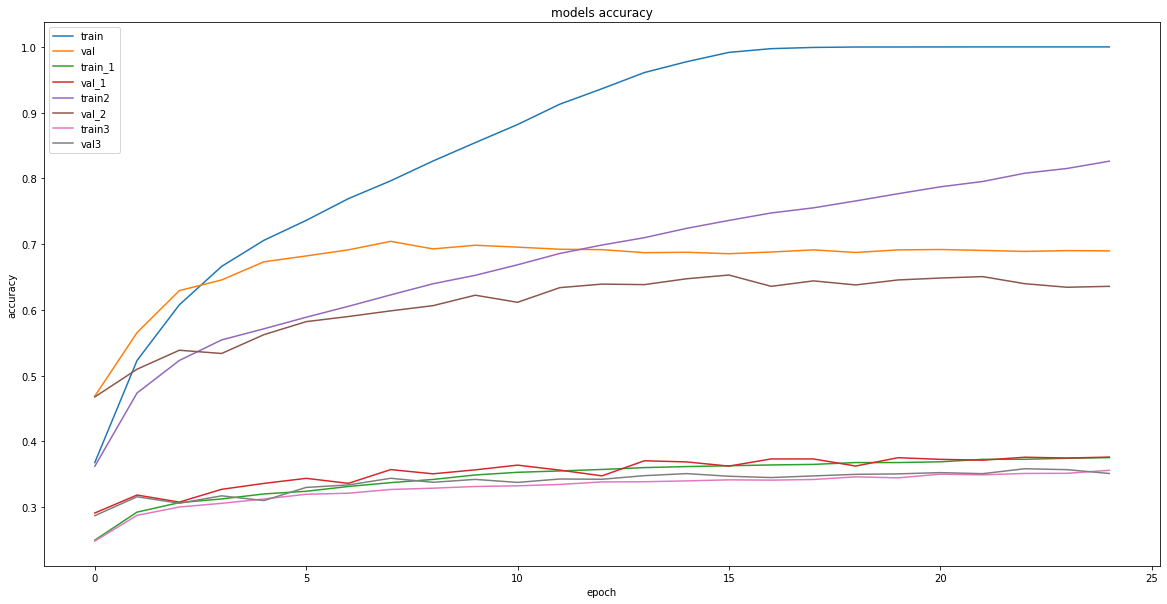

In [0]:
plt.figure(figsize=(20,10))
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
 
plt.plot(history1_5.history['accuracy'])
plt.plot(history1_5.history['val_accuracy'])
 
plt.plot(history1_6.history['accuracy'])
plt.plot(history1_6.history['val_accuracy'])
 
plt.plot(history1_7.history['accuracy'])
plt.plot(history1_7.history['val_accuracy'])
 
plt.title('models accuracy')
 
plt.ylabel('accuracy')
plt.xlabel('epoch')
 
#Baseline --> train - val
#model1_5 --> train1 - val1 -l1reg
#model1_6 --> train2 - val2 -l2reg
#model1_7 --> train3 - val3 -l1-l2reg
plt.legend(['train', 'val', 'train_1', 'val_1', 'train2' , 'val_2', 'train3', 'val3'])
plt.show()

Legend:

- Baseline --> train - val
- model1_5 --> train1 - val1 -l1reg
- model1_6 --> train2 - val2 -l2reg
- model1_7 --> train3 - val3 -l1-l2reg

My analyse:

According to the graph above, the accuracy of the model, after using l2 regularization, decreased. However, using l2 regularization also decreased the overfitting. (Not much)

Using l1 and l1-l2 regularization made the model to be overfitted. Therefore, it is not good to use l1 and l1-l2 regularization in this model.

***Visualizing AUC***

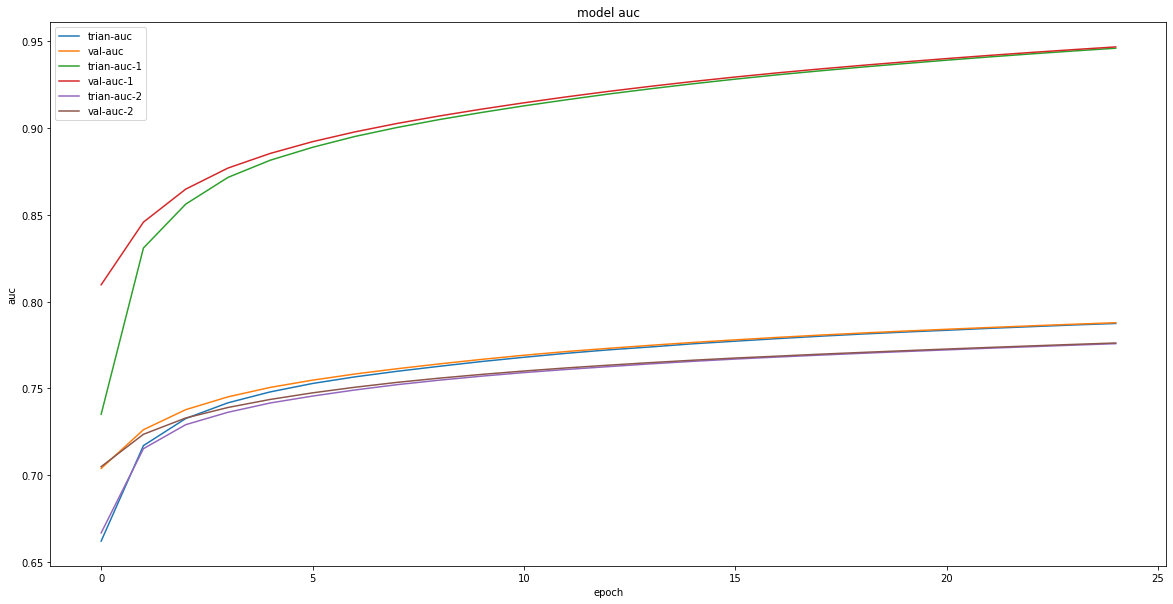

In [0]:
plt.figure(figsize=(20,10))
 
plt.plot(history1_5.history['auc_4'])
plt.plot(history1_5.history['val_auc_4'])
 
plt.plot(history1_6.history['auc_5'])
plt.plot(history1_6.history['val_auc_5'])
 
plt.plot(history1_7.history['auc_6'])
plt.plot(history1_7.history['val_auc_6'])
 
 
plt.title('model auc')
 
plt.ylabel('auc')
plt.xlabel('epoch')
 
 
#model1_5 --> train - val - l1reg
#model1_6 --> train1 - val1 - l2reg
#model1_7 --> train2 - val2 - l1-l2reg
plt.legend(['trian-auc', 'val-auc','trian-auc-1', 'val-auc-1', 'trian-auc-2','val-auc-2'])
plt.show()

Legend:

- model1_5 --> train - val - l1reg
- model1_6 --> train1 - val1 - l2reg
- model1_7 --> train2 - val2 - l1-l2reg

My analyse:

According to auc graph, by using l2 regularization, the overfit has not happened!

However, it is obvious that using l1 and l1-l2 regularization is not good. Because you can see that they made the model to be overfitted.

***Visualizing precision and recall***


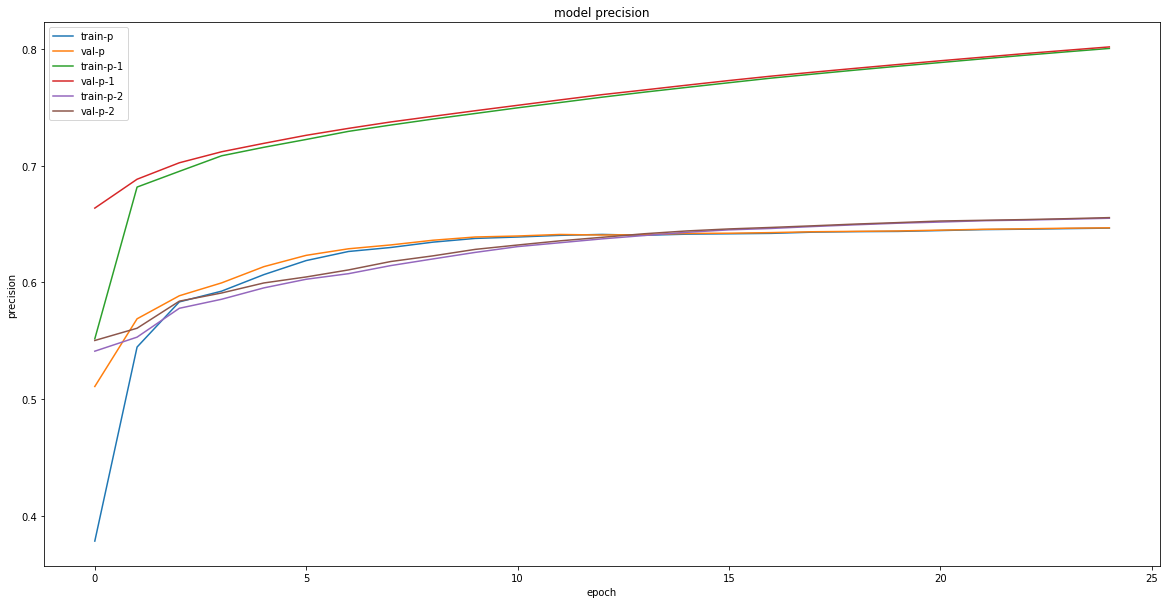

In [0]:
plt.figure(figsize=(20,10))
 
plt.plot(history1_5.history['precision_4'])
plt.plot(history1_5.history['val_precision_4'])
 
plt.plot(history1_6.history['precision_5'])
plt.plot(history1_6.history['val_precision_5'])
 
plt.plot(history1_7.history['precision_6'])
plt.plot(history1_7.history['val_precision_6'])
 
plt.title('model precision')
 
plt.ylabel('precision')
plt.xlabel('epoch')
 
#model1_5 --> train - val - l1reg
#model1_6 --> train1 - val1 - l2reg
#model1_7 --> train2 - val2 - l1-l2reg
plt.legend(['train-p', 'val-p' ,'train-p-1', 'val-p-1' , 'train-p-2', 'val-p-2'])
plt.show()

Legend:

- model1_5 --> train - val - l1reg
- model1_6 --> train1 - val1 - l2reg
- model1_7 --> train2 - val2 - l1-l2reg

My analyse:

According to the precision, by using l2 regularization, the overfit has not happened. However, using l1 and l1-l2 regularization made the model's precision less.

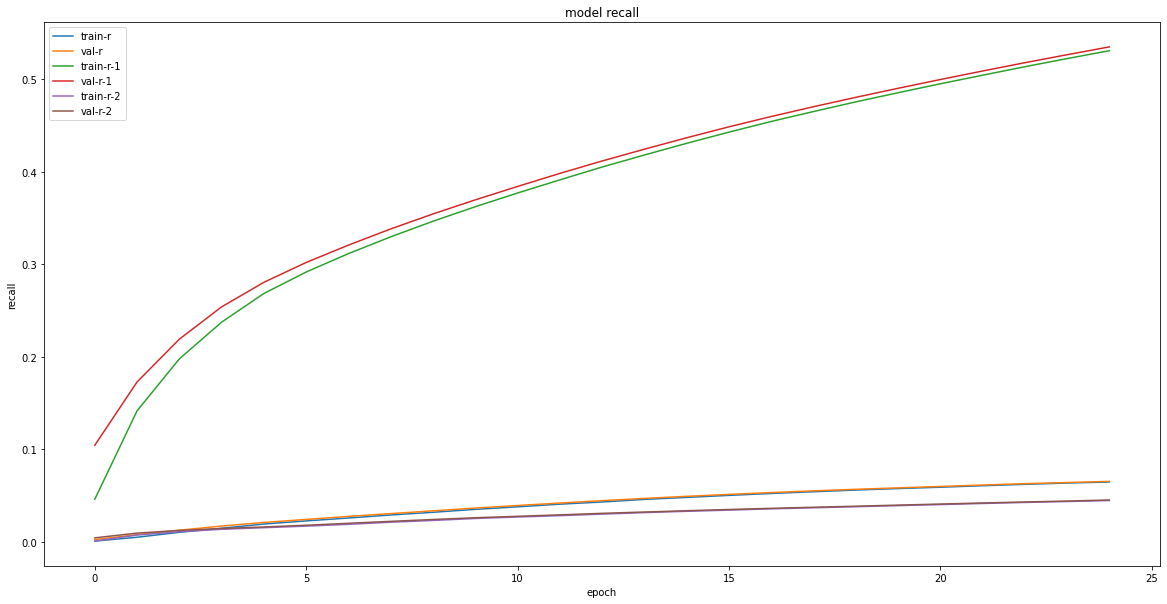

In [0]:
plt.figure(figsize=(20,10))
 
plt.plot(history1_5.history['recall_4'])
plt.plot(history1_5.history['val_recall_4'])
 
plt.plot(history1_6.history['recall_5'])
plt.plot(history1_6.history['val_recall_5'])
 
plt.plot(history1_7.history['recall_6'])
plt.plot(history1_7.history['val_recall_6'])
 
plt.title('model recall')
 
plt.ylabel('recall')
plt.xlabel('epoch')
 
#model1_5 --> train - val - l1reg
#model1_6 --> train1 - val1 - l2reg
#model1_7 --> train2 - val2 - l1-l2reg
 
plt.legend(['train-r', 'val-r','train-r-1', 'val-r-1', 'train-r-2', 'val-r-2'])
plt.show()

Legend:

- model1_5 --> train - val - l1reg
- model1_6 --> train1 - val1 - l2reg
- model1_7 --> train2 - val2 - l1-l2reg

My analyse:

According to the graph above, by using l2 regularization, the overfit has not happend that much. However, using l1 and l1-l2 regularization has made the model to be underfitted!

Note: the recall is not close to the precision which is not good observation.

# ***Visualize evaluation after  simplifying***

***Accuracy***

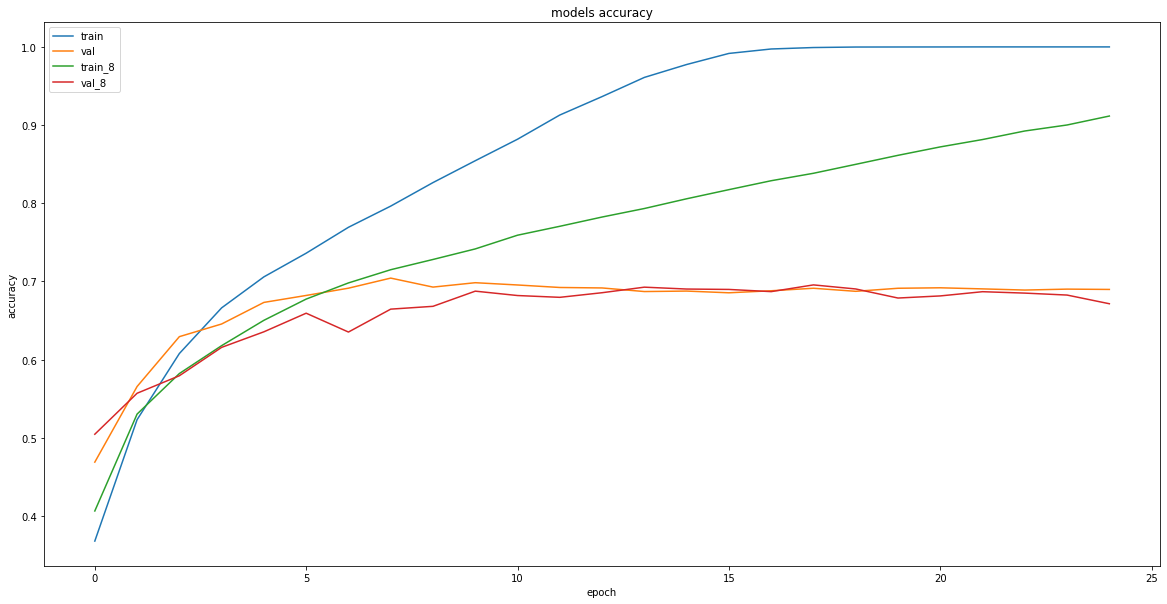

In [0]:
plt.figure(figsize=(20,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot(history1_8.history['accuracy'])
plt.plot(history1_8.history['val_accuracy'])

plt.title('models accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

#Baseline --> train - val
#model1_8 --> train8 - val8
plt.legend(['train', 'val', 'train_8', 'val_8'])

plt.show()

Legend:
- Baseline --> train - val
- model1_8 --> train8 - val8

My analyse:

Although the accuracy decreased by simplifying the model, but the accuracy of the validation of two models are close.
However,  ovefitting which has been less by simplifying the model is still the problem that we have!

# ***Visualize evaluation after using early stopping***

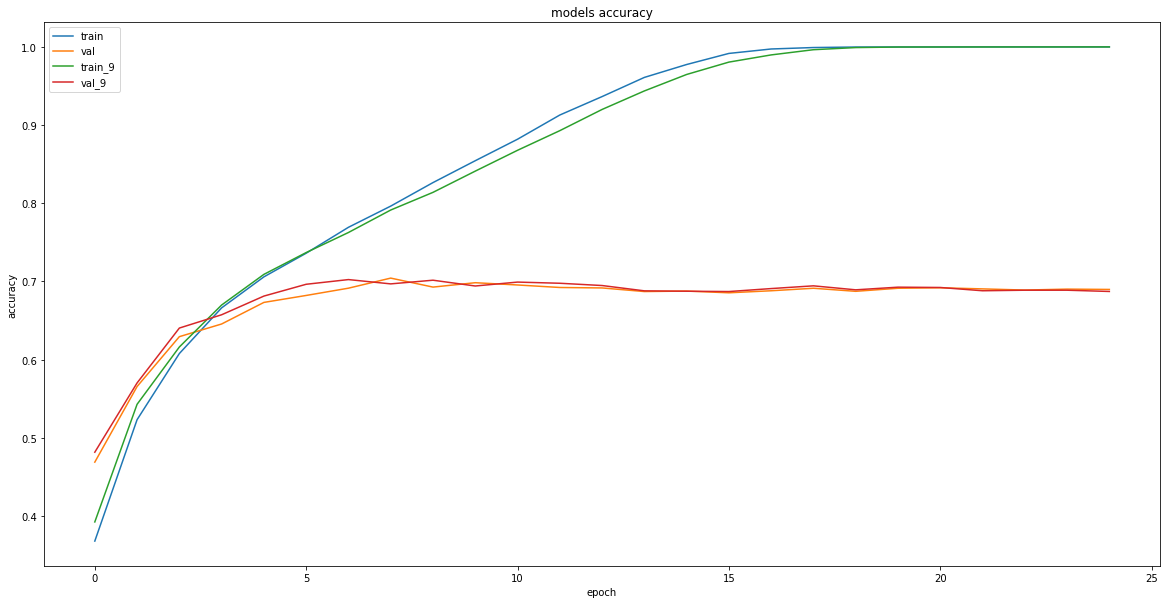

In [0]:
plt.figure(figsize=(20,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot(history1_9.history['accuracy'])
plt.plot(history1_9.history['val_accuracy'])

plt.title('models accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

#Baseline --> train - val
#model1_9 --> train9 - val9
plt.legend(['train', 'val', 'train_9', 'val_9'])
plt.show()

Legend:
- Baseline --> train - val
- model1_9 --> train9 - val9

My analyse:

Early stopping did not worked like I expected to! It is because of the parameters that I gave as an input to early stopping.

# **Conclusion**

In this experiment, some of the actions for avoiding overfitting, made the model to be underfitted! Therefore, not all of the actions are useful in all the models. I'll show the best and worth choices in my experiment below.

In [0]:
pt = PrettyTable()
pt_2 = PrettyTable()

#drop out  ✔
pt.field_names =  ["Dropout", "0.2", "0.3" , "0.4" , "0.5"]
pt.add_row(["best choice","✔", " ", " ", " "])
pt.add_row(["worth choice"," ", " ", " ", "✔"])

#regularization
pt_2.field_names = ["Regularization" , "l1" , "l2", "l1-l2"]
pt_2.add_row(["best choice", " ", "✔",  " "])
pt_2.add_row(["worth choice","✔", " ", "✔"])


print(pt)
print("\n")
print(pt_2)

+--------------+-----+-----+-----+-----+
|   Dropout    | 0.2 | 0.3 | 0.4 | 0.5 |
+--------------+-----+-----+-----+-----+
| best choice  |  ✔  |     |     |     |
| worth choice |     |     |     |  ✔  |
+--------------+-----+-----+-----+-----+


+----------------+----+----+-------+
| Regularization | l1 | l2 | l1-l2 |
+----------------+----+----+-------+
|  best choice   |    | ✔  |       |
|  worth choice  | ✔  |    |   ✔   |
+----------------+----+----+-------+
